# Warming levels
 This notebook will demonstrate a typical workflow for showing indicators by warming levels.

First, initialize your project catalog.

In [2]:
# Basic imports
import xscen as xs
from pathlib import Path
import xarray as xr
from matplotlib import pyplot as plt
import xesmf as xe

project = {"title": "example-warminglevel",
           "description": "This is an example catalog for xscen's documentation."
          }

pcat = xs.ProjectCatalog(f"{Path().absolute()}/samples/example-wl.json", project=project, create=True, overwrite=True)

Successfully wrote ESM catalog json file to: file:///home/rondeau/python/github/xscen/docs/notebooks/samples/example-wl.json


In [3]:
# Extract and regrid the data needed for the Tutorial

cat_sim = xs.search_data_catalogs(data_catalogs=["samples/tutorial-catalog.json"],
                                  variables_and_freqs={"tas": "D"},
                                  other_search_criteria={'source': 'NorESM2-MM', 'activity':'ScenarioMIP'},
                                  periods=[[2000, 2050]],
                                  match_hist_and_fut=True,
                                  restrict_members={"ordered": 1}
                                 )

region = {
    "name": "example-region",
    "method": "bbox",
    "buffer": 1.5,
    "bbox": {
        "lon_bnds": [-68.5, -67.5],
        "lat_bnds": [48.5, 49.5]
    }
}

ds_grid = xe.util.cf_grid_2d(-68.5, -67.5, 0.25, 48.5, 49.5, 0.25)
ds_grid.attrs['cat:domain']='region1'
for ds_id, dc in cat_sim.items():
    dset_dict = xs.extract_dataset(catalog=dc,
                                   region=region,
                                   xr_open_kwargs={'drop_variables': ['height', 'time_bnds']}
                                  )

    
    for key, ds in dset_dict.items():
        ds = xs.regrid_dataset(ds=ds, ds_grid=ds_grid, weights_location=f"samples/gs-weights", to_level='extracted')
        filename = f"samples/wl_{ds.attrs['cat:id']}.{ds.attrs['cat:domain']}.{ds.attrs['cat:processing_level']}.{ds.attrs['cat:frequency']}.zarr"
        chunks = xs.io.estimate_chunks(ds, dims=["time"], target_mb=50)
        xs.save_to_zarr(ds, filename, rechunk=chunks, mode='o')
        pcat.update_from_ds(ds=ds, path=filename, info_dict={'format':'zarr'})

2022-11-18 15:54:25,490 - xscen.extract - INFO - Catalog opened: <tutorial-catalog catalog with 10 dataset(s) from 10 asset(s)> from 1 files.
2022-11-18 15:54:25,492 - xscen.extract - INFO - Dispatching historical dataset to future experiments.
2022-11-18 15:54:25,529 - xscen.extract - INFO - 10 assets matched the criteria : {'source': 'NorESM2-MM', 'activity': 'ScenarioMIP'}.
2022-11-18 15:54:25,723 - xscen.extract - INFO - Iterating over 5 potential datasets.
2022-11-18 15:54:26,458 - xscen.extract - INFO - Found 5 with all variables requested and corresponding to the criteria.
2022-11-18 15:54:26,489 - xscen.extract - INFO - Dataset NCC_NorESM2-MM_CMIP6_example-region_ssp245_ScenarioMIP has 2 valid members. Restricting as per requested.
2022-11-18 15:54:26,508 - xscen.extract - INFO - Removing CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r2i1p1f1_example-region from the results.

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


## Subsetting the time period

``xs.subset_warming_level`` is used to subset a dataset for a window over which a given global warming level is reached.

Warming levels are computed individually in order to be able to calculate the ensemble weights properly (see [subsection below](#Ensemble-statistics)).

The arguments of ``xs.subset_warming_level`` are:

- `ds`: input dataset.
- `wl`: warming level.
- `window`: Number of years in the centered window during which the warming level is reached. Note that in the case of an even number, the IPCC standard is used (-n/2+1, +n/2).
- `tas_baseline_period`: The period over which the warming level is calculated, equivalent to "+0°C". Defaults to 1850-1900.
- `ignore_member`: The default `warming_level_csv` only contains data for 1 member. If you want a result regardless of the realization number, set this to True.
- `to_level`: Contrary to other methods, you can use "{wl}", "{period0}" and "{period1}" in the string to dynamically include `wl`, 'tas_baseline_period[0]' and 'tas_baseline_period[1]' in the `processing_level`.
- `wl_dim`: The string used to fill the new `warminglevel` dimension. You can use "{wl}", "{period0}" and "{period1}" in the string to dynamically include `wl`, `tas_baseline_period[0]` and `tas_baseline_period[1]`. If None, no new dimension will be added.
    
If the source, experiment, (member), and warming level are not found in the csv. The function returns None.



In [4]:
dict_input = pcat.search(processing_level='extracted').to_dataset_dict(xarray_open_kwargs={'decode_timedelta':False})
wls = [1, 1.5]
for wl in wls:
    for id_input, ds_input in dict_input.items():
        
        ds_wl = xs.subset_warming_level(
            ds_input,
            wl=wl,
            window=20,
        )

        if ds_wl: # check that the dataset is not None (if wl was not reached)
            # Save and update the catalog
            filename = f"samples/wl_{ds_wl.attrs['cat:id']}.{ds_wl.attrs['cat:domain']}.{ds_wl.attrs['cat:processing_level']}.{ds_wl.attrs['cat:frequency']}.zarr"
            xs.save_to_zarr(ds_wl, filename, mode='o')
            pcat.update_from_ds(ds=ds_wl, path=filename, info_dict={'format':'zarr'})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


2022-11-18 15:55:41,494 - xscen.extract - INFO - Computing warming level +1C for id: CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp585_r1i1p1f1_example-region from column: CMIP6_NorESM2-MM_ssp585_r1i1p1f1.
2022-11-18 15:55:41,995 - xscen.extract - INFO - Computing warming level +1C for id: CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1f1_example-region from column: CMIP6_NorESM2-MM_ssp245_r1i1p1f1.
2022-11-18 15:55:42,467 - xscen.extract - INFO - Computing warming level +1C for id: CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp370_r1i1p1f1_example-region from column: CMIP6_NorESM2-MM_ssp370_r1i1p1f1.
2022-11-18 15:55:42,912 - xscen.extract - INFO - Computing warming level +1C for id: CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp126_r1i1p1f1_example-region from column: CMIP6_NorESM2-MM_ssp126_r1i1p1f1.
2022-11-18 15:55:43,312 - xscen.extract - INFO - Computing warming level +1.5C for id: CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp585_r1i1p1f1_example-region from column: CMIP6_NorESM2-MM_ssp585_r1i1p1f1.
2022-11-18 15:55:4

In [5]:
ds_wl = pcat.search(id="CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp585_r1i1p1f1_example-region", processing_level="warminglevel-1.5vs1850-1900").to_dask()
display(ds_wl)

<xarray.Dataset>
Dimensions:       (lat: 4, lon: 4, warminglevel: 1, time: 7300)
Coordinates:
  * lat           (lat) float64 48.62 48.88 49.12 49.38
  * lon           (lon) float64 -68.38 -68.12 -67.88 -67.62
  * time          (time) object 2030-01-01 00:00:00 ... 2049-12-31 00:00:00
  * warminglevel  (warminglevel) object '+1.5Cvs1850-1900'
Data variables:
    tas           (warminglevel, time, lat, lon) float32 dask.array<chunksize=(1, 7300, 4, 4), meta=np.ndarray>
Attributes: (12/62)
    Conventions:               CF-1.7 CMIP-6.2
    branch_time:               0.0
    branch_time_in_child:      0.0
    cat:_data_format_:         zarr
    cat:activity:              ScenarioMIP
    cat:date_end:              2049-12-31 00:00:00
    ...                        ...
    table_id:                  day
    table_info:                Creation Date:(24 July 2019) MD5:0bb394a356ef9...
    title:                     NorESM2-MM output prepared for CMIP6
    variable_id:               tas
    variant_label:             r1i1p1f1
    version_id:                v20191108

## Producing the horizons

The extracted and subsetted dataset can be passed to ``xs.aggregate.produce_horizon`` to calculate indicators and the climatological mean. 

Since the years are meaningless for warming levels, and are even detrimental to making ensemble statistics, the function also formats the output such that 'time' and 'year' information is removed, while the seasons/months are unstacked to different coordinates. Hence, the single dataset outputed can contain indicators of different frequencies. 

The arguments of ``xs.aggregate.produce_horizon`` are:

- `ds`: input dataset.
- `indicators`: As in `compute_indicators`
- `period`: Period to cut. If None, the whole time series is used. Useful in the case when the timeseries was already extracted by ``xs.extract.subset_warming_level``.
- `to_level`:The processing level to assign to the output. Use "{wl}", "{period0}" and "{period1}" in the string to dynamically include the first value of the `warminglevel` coord of ds if it exists, `period[0]` and `period[1]`.

In [6]:
dict_input = pcat.search(processing_level='^warminglevel+').to_dataset_dict(xarray_open_kwargs={'decode_timedelta':False})

for id_input, ds_input in dict_input.items():
    
    ds_hor_wl = xs.produce_horizon(
        ds_input,
        indicators = 'samples/indicators.yml',
        to_level ='clim{wl}'
    )

    # Save
    filename = f"samples/wl_{ds_hor_wl.attrs['cat:id']}.{ds_hor_wl.attrs['cat:domain']}.{ds_hor_wl.attrs['cat:processing_level']}.{ds_hor_wl.attrs['cat:frequency']}.zarr"
    xs.save_to_zarr(ds_hor_wl, filename,  mode='o')
    pcat.update_from_ds(ds=ds_hor_wl, path=filename, info_dict={'format':'zarr'})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


2022-11-18 15:56:16,946 - xscen.indicators - INFO - 1 - Computing growing_degree_days.
2022-11-18 15:56:17,295 - xscen.indicators - INFO - 2 - Computing tg_min.
2022-11-18 15:56:17,847 - xscen.indicators - INFO - 1 - Computing growing_degree_days.
2022-11-18 15:56:18,168 - xscen.indicators - INFO - 2 - Computing tg_min.
2022-11-18 15:56:18,727 - xscen.indicators - INFO - 1 - Computing growing_degree_days.
2022-11-18 15:56:19,270 - xscen.indicators - INFO - 2 - Computing tg_min.
2022-11-18 15:56:20,021 - xscen.indicators - INFO - 1 - Computing growing_degree_days.
2022-11-18 15:56:20,556 - xscen.indicators - INFO - 2 - Computing tg_min.
2022-11-18 15:56:21,258 - xscen.indicators - INFO - 1 - Computing growing_degree_days.
2022-11-18 15:56:21,694 - xscen.indicators - INFO - 2 - Computing tg_min.
2022-11-18 15:56:22,399 - xscen.indicators - INFO - 1 - Computing growing_degree_days.
2022-11-18 15:56:22,834 - xscen.indicators - INFO - 2 - Computing tg_min.
2022-11-18 15:56:23,518 - xscen.in

In [7]:
display(ds_hor_wl)

<xarray.Dataset>
Dimensions:              (lat: 4, lon: 4, horizon: 1)
Coordinates:
  * lat                  (lat) float64 48.62 48.88 49.12 49.38
  * lon                  (lon) float64 -68.38 -68.12 -67.88 -67.62
  * horizon              (horizon) object '+1Cvs1850-1900'
Data variables:
    growing_degree_days  (horizon, lat, lon) float64 dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    tg_min               (horizon, lat, lon) float64 dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
Attributes: (12/61)
    Conventions:               CF-1.7 CMIP-6.2
    branch_time:               0.0
    branch_time_in_child:      0.0
    cat:_data_format_:         zarr
    cat:activity:              ScenarioMIP
    cat:date_end:              2032-12-31 00:00:00
    ...                        ...
    table_id:                  day
    table_info:                Creation Date:(24 July 2019) MD5:0bb394a356ef9...
    title:                     NorESM2-MM output prepared for CMIP6
    variable_id:               tas
    variant_label:             r1i1p1f1
    version_id:                v20191108

### Reference horizon

For the purpose of deltas and future ensemble statistics, a time-based reference horizon is often required. That dataset can also be created by calling ``xs.aggregate.produce_horizon``, but with the reference period:

In [8]:
dict_input = pcat.search(processing_level='extracted').to_dataset_dict(xarray_open_kwargs={'decode_timedelta':False})
for id_input, ds_input in dict_input.items():
    
    ds_hor = xs.produce_horizon(
        ds_input,
        period=['2001','2020'],
        indicators = 'samples/indicators.yml',
        to_level ='clim{period0}-{period1}'
    )
    
    
    # Save
    filename = f"samples/wl_{ds_hor.attrs['cat:id']}.{ds_hor.attrs['cat:domain']}.{ds_hor.attrs['cat:processing_level']}.{ds_hor.attrs['cat:frequency']}.zarr"
    xs.save_to_zarr(ds_hor, filename,  mode='o')
    pcat.update_from_ds(ds=ds_hor, path=filename, info_dict={'format':'zarr'})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


2022-11-18 15:56:32,532 - xscen.indicators - INFO - 1 - Computing growing_degree_days.
2022-11-18 15:56:32,807 - xscen.indicators - INFO - 2 - Computing tg_min.
2022-11-18 15:56:33,111 - xscen.indicators - INFO - 1 - Computing growing_degree_days.
2022-11-18 15:56:33,399 - xscen.indicators - INFO - 2 - Computing tg_min.
2022-11-18 15:56:33,685 - xscen.indicators - INFO - 1 - Computing growing_degree_days.
2022-11-18 15:56:33,939 - xscen.indicators - INFO - 2 - Computing tg_min.
2022-11-18 15:56:34,162 - xscen.indicators - INFO - 1 - Computing growing_degree_days.
2022-11-18 15:56:34,360 - xscen.indicators - INFO - 2 - Computing tg_min.


In [9]:
display(ds_hor)

<xarray.Dataset>
Dimensions:              (lat: 4, lon: 4, horizon: 1)
Coordinates:
  * lat                  (lat) float64 48.62 48.88 49.12 49.38
  * lon                  (lon) float64 -68.38 -68.12 -67.88 -67.62
  * horizon              (horizon) <U9 '2001-2020'
Data variables:
    growing_degree_days  (horizon, lat, lon) float32 1.531e+03 ... 1.324e+03
    tg_min               (horizon, lat, lon) float32 245.7 246.0 ... 246.2 246.8
Attributes: (12/61)
    Conventions:               CF-1.7 CMIP-6.2
    branch_time:               0.0
    branch_time_in_child:      0.0
    cat:_data_format_:         zarr
    cat:activity:              ScenarioMIP
    cat:date_end:              2050-12-31 00:00:00
    ...                        ...
    table_id:                  day
    table_info:                Creation Date:(24 July 2019) MD5:0bb394a356ef9...
    title:                     NorESM2-MM output prepared for CMIP6
    variable_id:               tas
    variant_label:             r1i1p1f1
    version_id:                v20191108

## Deltas

This step is done as in the [Getting Started](getting_started.ipynb#Computing-deltas) Notebook, with the difference that for each simulation, the warming level and the reference horizon need to be concatenated in order to pass them to `xs.compute_deltas`.

In [10]:
dict_wl = pcat.search(processing_level='^clim+.*C').to_dataset_dict(xarray_open_kwargs={'decode_timedelta':False})
ref_period='2001-2020'
dict_hor = pcat.search(processing_level=f'clim{ref_period}').to_dataset_dict(xarray_open_kwargs={'decode_timedelta':False})

for id_wl, ds_wl in dict_wl.items():
    
    # for this simulation, find the accompanying reference horizon
    level = ds_wl.attrs['cat:processing_level']
    id_hor = id_wl.replace(level,f'clim{ref_period}')
    ds_hor = dict_hor[id_hor]
    
    # concat warming level and reference
    ds_concat= xr.concat([ds_wl, ds_hor], dim='horizon')
    
    # compute delta
    ds_delta= xs.aggregate.compute_deltas(
        ds=ds_concat,
        reference_horizon=ref_period,
        to_level=f'delta-{level}'
    )
    
    # Save
    filename = f"samples/wl_{ds_delta.attrs['cat:id']}.{ds_delta.attrs['cat:domain']}.{ds_delta.attrs['cat:processing_level']}.{ds_delta.attrs['cat:frequency']}.zarr"
    xs.save_to_zarr(ds_delta, filename, mode='o')
    pcat.update_from_ds(ds=ds_delta, path=filename, info_dict={'format':'zarr'})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


In [11]:
display(ds_delta)

<xarray.Dataset>
Dimensions:                              (horizon: 2, lat: 4, lon: 4)
Coordinates:
  * horizon                              (horizon) object '+1Cvs1850-1900' '2...
  * lat                                  (lat) float64 48.62 48.88 49.12 49.38
  * lon                                  (lon) float64 -68.38 -68.12 ... -67.62
Data variables:
    growing_degree_days_delta_2001_2020  (horizon, lat, lon) float64 dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    tg_min_delta_2001_2020               (horizon, lat, lon) float64 dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
Attributes: (12/62)
    Conventions:               CF-1.7 CMIP-6.2
    branch_time:               0.0
    branch_time_in_child:      0.0
    cat:_data_format_:         zarr
    cat:activity:              ScenarioMIP
    cat:date_end:              2041-12-31 00:00:00
    ...                        ...
    table_info:                Creation Date:(24 July 2019) MD5:0bb394a356ef9...
    title:                     NorESM2-MM output prepared for CMIP6
    variable_id:               tas
    variant_label:             r1i1p1f1
    version_id:                v20191108
    cat:variable:              tg_min,growing_degree_days

## Ensemble statistics

Even more than with time-based horizons, the first step of ensemble statistics should be to generate the weights. Indeed, if a model has 3 experiments reaching a given warming level, we want it to have the same weight as a model with only 2 experiments reaching that warming.

<div class="alert alert-warning"> <b>Warning</b>: `xs.ensembles.generate_weights` is currently purely based on metadata, and thus cannot distinguish subtleties about which realization reaches which warming level if multiple experiments are concatenated together before passing them to the function. The results are likely to be wrong, which is why each warming level needs to be computed individually.
</div>

Next, the weights and the datasets can be passed to `xs.ensemble_stats` to calculate the ensemble statistics.


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


2022-11-18 15:57:56,015 - xscen.ensembles - INFO - Creating ensemble with 4 simulations and calculating ensemble_mean_std_max_min.
Removing samples/wl_CMIP6_ScenarioMIP_NCC_NorESM2-MM_r1i1p1f1_region1.region1.ensemble-deltas+1C.fx.zarr/growing_degree_days_delta_2001_2020_mean to overwrite.
Removing samples/wl_CMIP6_ScenarioMIP_NCC_NorESM2-MM_r1i1p1f1_region1.region1.ensemble-deltas+1C.fx.zarr/growing_degree_days_delta_2001_2020_stdev to overwrite.
Removing samples/wl_CMIP6_ScenarioMIP_NCC_NorESM2-MM_r1i1p1f1_region1.region1.ensemble-deltas+1C.fx.zarr/growing_degree_days_delta_2001_2020_max to overwrite.
Removing samples/wl_CMIP6_ScenarioMIP_NCC_NorESM2-MM_r1i1p1f1_region1.region1.ensemble-deltas+1C.fx.zarr/growing_degree_days_delta_2001_2020_min to overwrite.
Removing samples/wl_CMIP6_ScenarioMIP_NCC_NorESM2-MM_r1i1p1f1_region1.region1.ensemble-deltas+1C.fx.zarr/tg_min_delta_2001_2020_mean to overwrite.
Removing samples/wl_CMIP6_ScenarioMIP_NCC_NorESM2-MM_r1i1p1f1_region1.region1.ensem

2022-11-18 15:57:56,687 - xscen.ensembles - INFO - Creating ensemble with 3 simulations and calculating ensemble_mean_std_max_min.
Removing samples/wl_CMIP6_ScenarioMIP_NCC_NorESM2-MM_r1i1p1f1_region1.region1.ensemble-deltas+1.5C.fx.zarr/growing_degree_days_delta_2001_2020_mean to overwrite.
Removing samples/wl_CMIP6_ScenarioMIP_NCC_NorESM2-MM_r1i1p1f1_region1.region1.ensemble-deltas+1.5C.fx.zarr/growing_degree_days_delta_2001_2020_stdev to overwrite.
Removing samples/wl_CMIP6_ScenarioMIP_NCC_NorESM2-MM_r1i1p1f1_region1.region1.ensemble-deltas+1.5C.fx.zarr/growing_degree_days_delta_2001_2020_max to overwrite.
Removing samples/wl_CMIP6_ScenarioMIP_NCC_NorESM2-MM_r1i1p1f1_region1.region1.ensemble-deltas+1.5C.fx.zarr/growing_degree_days_delta_2001_2020_min to overwrite.
Removing samples/wl_CMIP6_ScenarioMIP_NCC_NorESM2-MM_r1i1p1f1_region1.region1.ensemble-deltas+1.5C.fx.zarr/tg_min_delta_2001_2020_mean to overwrite.
Removing samples/wl_CMIP6_ScenarioMIP_NCC_NorESM2-MM_r1i1p1f1_region1.reg

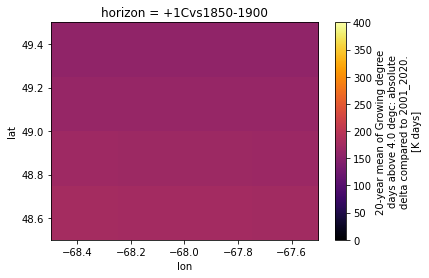

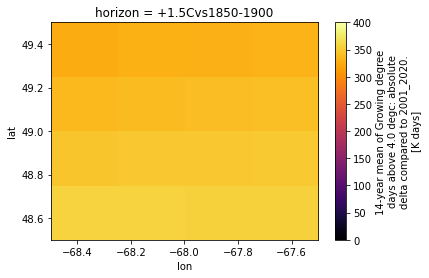

In [14]:
for wl in wls:
    datasets= pcat.search(processing_level=f'delta-clim+{wl}Cvs1850-1900').to_dataset_dict(xarray_open_kwargs={'decode_timedelta':False})

    weights = xs.ensembles.generate_weights(datasets=datasets,independence_level='all')

    ds_ens = xs.ensemble_stats(datasets=datasets,
                               common_attrs_only=True,
                               weights= weights,
                               statistics={'ensemble_mean_std_max_min':None},
                               to_level= f'ensemble-deltas+{wl}C')
    
    # It is sometimes useful to keep track of how many realisations made the ensemble.
    ds_ens.horizon.attrs['ensemble_size']= len(datasets)

    filename = f"samples/wl_{ds_ens.attrs['cat:id']}.{ds_ens.attrs['cat:domain']}.{ds_ens.attrs['cat:processing_level']}.{ds_ens.attrs['cat:frequency']}.zarr"
    xs.save_to_zarr(ds_ens, filename, mode='o')
    pcat.update_from_ds(ds=ds_ens, path=filename, info_dict={'format':'zarr'})
    
    # Create a figure
    plt.figure()
    ds_ens['growing_degree_days_delta_2001_2020_mean'].sel(horizon=f'+{wl}Cvs1850-1900').plot.imshow(vmin=0, vmax=400, cmap='inferno')

In [15]:
display(ds_ens)

<xarray.Dataset>
Dimensions:                                    (horizon: 2, lat: 4, lon: 4)
Coordinates:
  * horizon                                    (horizon) object '+1.5Cvs1850-...
  * lat                                        (lat) float64 48.62 ... 49.38
  * lon                                        (lon) float64 -68.38 ... -67.62
Data variables:
    growing_degree_days_delta_2001_2020_mean   (horizon, lat, lon) float64 dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    growing_degree_days_delta_2001_2020_stdev  (horizon, lat, lon) float64 dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    growing_degree_days_delta_2001_2020_max    (horizon, lat, lon) float64 dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    growing_degree_days_delta_2001_2020_min    (horizon, lat, lon) float64 dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    tg_min_delta_2001_2020_mean                (horizon, lat, lon) float64 dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    tg_min_delta_2001_2020_stdev               (horizon, lat, lon) float64 dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    tg_min_delta_2001_2020_max                 (horizon, lat, lon) float64 dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    tg_min_delta_2001_2020_min                 (horizon, lat, lon) float64 dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
Attributes: (12/57)
    Conventions:               CF-1.7 CMIP-6.2
    branch_time:               0.0
    branch_time_in_child:      0.0
    cat:_data_format_:         zarr
    cat:activity:              ScenarioMIP
    cat:domain:                region1
    ...                        ...
    title:                     NorESM2-MM output prepared for CMIP6
    variable_id:               tas
    variant_label:             r1i1p1f1
    version_id:                v20191108
    cat:id:                    CMIP6_ScenarioMIP_NCC_NorESM2-MM_r1i1p1f1_region1
    ensemble_size:             3